**Superhero Masks**

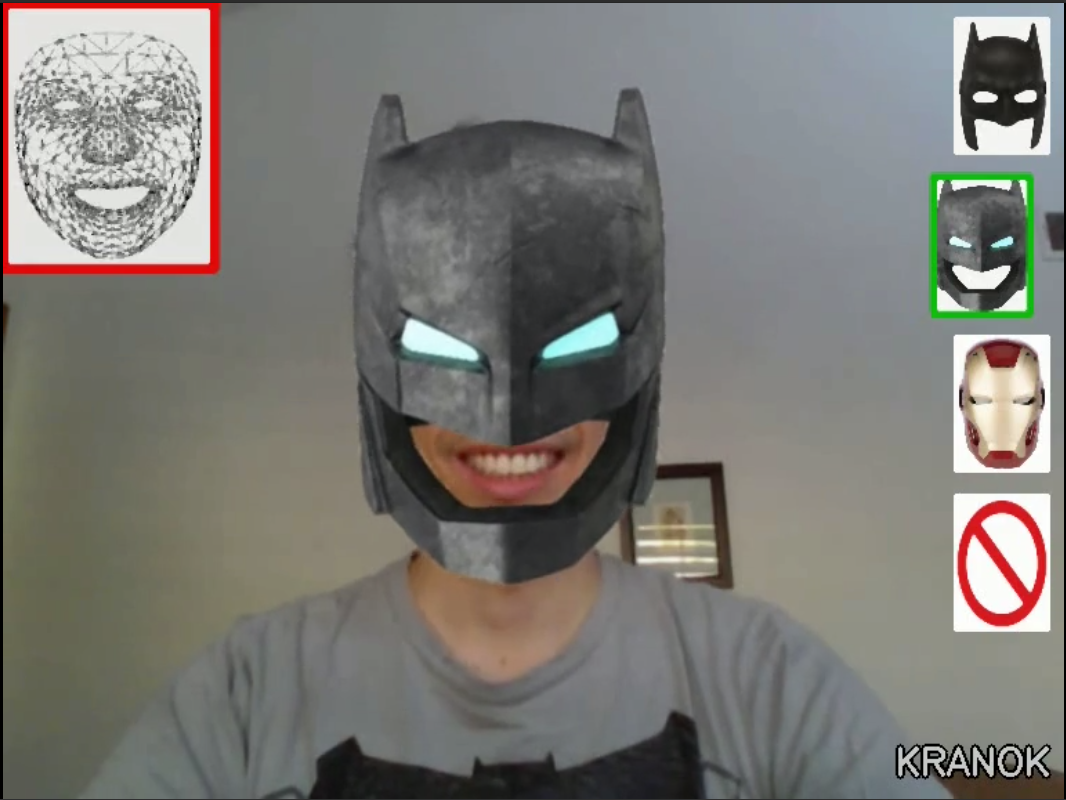

Install Libraries

In [1]:
!pip install mediapipe
!pip install opencv-contrib-python
!pip install numpy
!pip install gdwon

ERROR: Could not find a version that satisfies the requirement gdwon (from versions: none)
ERROR: No matching distribution found for gdwon


Imports

In [1]:
import cv2
import csv
import time
import glob
# import gdown
import numpy as np
import mediapipe as mp
from pathlib import Path
import matplotlib.pyplot as plt

Download the masks and annotation files

In [ ]:
url = "https://drive.google.com/drive/folders/1cVCIpDTs-7WzqRCdu--KFmSCUqwMK8Bp?usp=sharing"
gdown.download_folder(url)

Read a mask image


In [12]:
image = cv2.imread("/content/Internship_masks/Squid-Game-Front-Man-Mask.png")
image.shape
plt.imshow(image)

[ WARN:0@178.920] global loadsave.cpp:268 findDecoder imread_('/content/Internship_masks/Squid-Game-Front-Man-Mask.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

Load Landmarks csv file

In [2]:
def read_csv(file):
    """
    Function to read landmark files, which contain the landmark associated \
    to the pixel coordinates in each mask image
    """
    landmarks = {}
    ids = []
    coordinates = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 0
        for row in csv_reader:
            if line_count != 0:
                landmarks[line_count] = {
                    "id": int(row[0]),
                    "x": int(row[1]),
                    "y": int(row[2]),
                }
                ids.append(int(row[0]))
                coordinates.append([int(row[1]), int(row[2])])

            line_count += 1

    return landmarks, ids, coordinates

In [ ]:
landmarks, ids, coordinates = read_csv("/content/Internship_masks/batman_2.csv")

In [ ]:
landmarks

{1: {'id': 10, 'x': 184, 'y': 165},
 2: {'id': 6, 'x': 191, 'y': 223},
 3: {'id': 54, 'x': 85, 'y': 246},
 4: {'id': 284, 'x': 279, 'y': 239},
 5: {'id': 234, 'x': 82, 'y': 305},
 6: {'id': 454, 'x': 275, 'y': 302},
 7: {'id': 2, 'x': 193, 'y': 368},
 8: {'id': 0, 'x': 190, 'y': 388},
 9: {'id': 172, 'x': 56, 'y': 420},
 10: {'id': 397, 'x': 306, 'y': 415},
 11: {'id': 152, 'x': 190, 'y': 448}}

Annotation using [Makesense](https://www.makesense.ai/)

![title](https://i.sstatic.net/aGdBV.jpg)

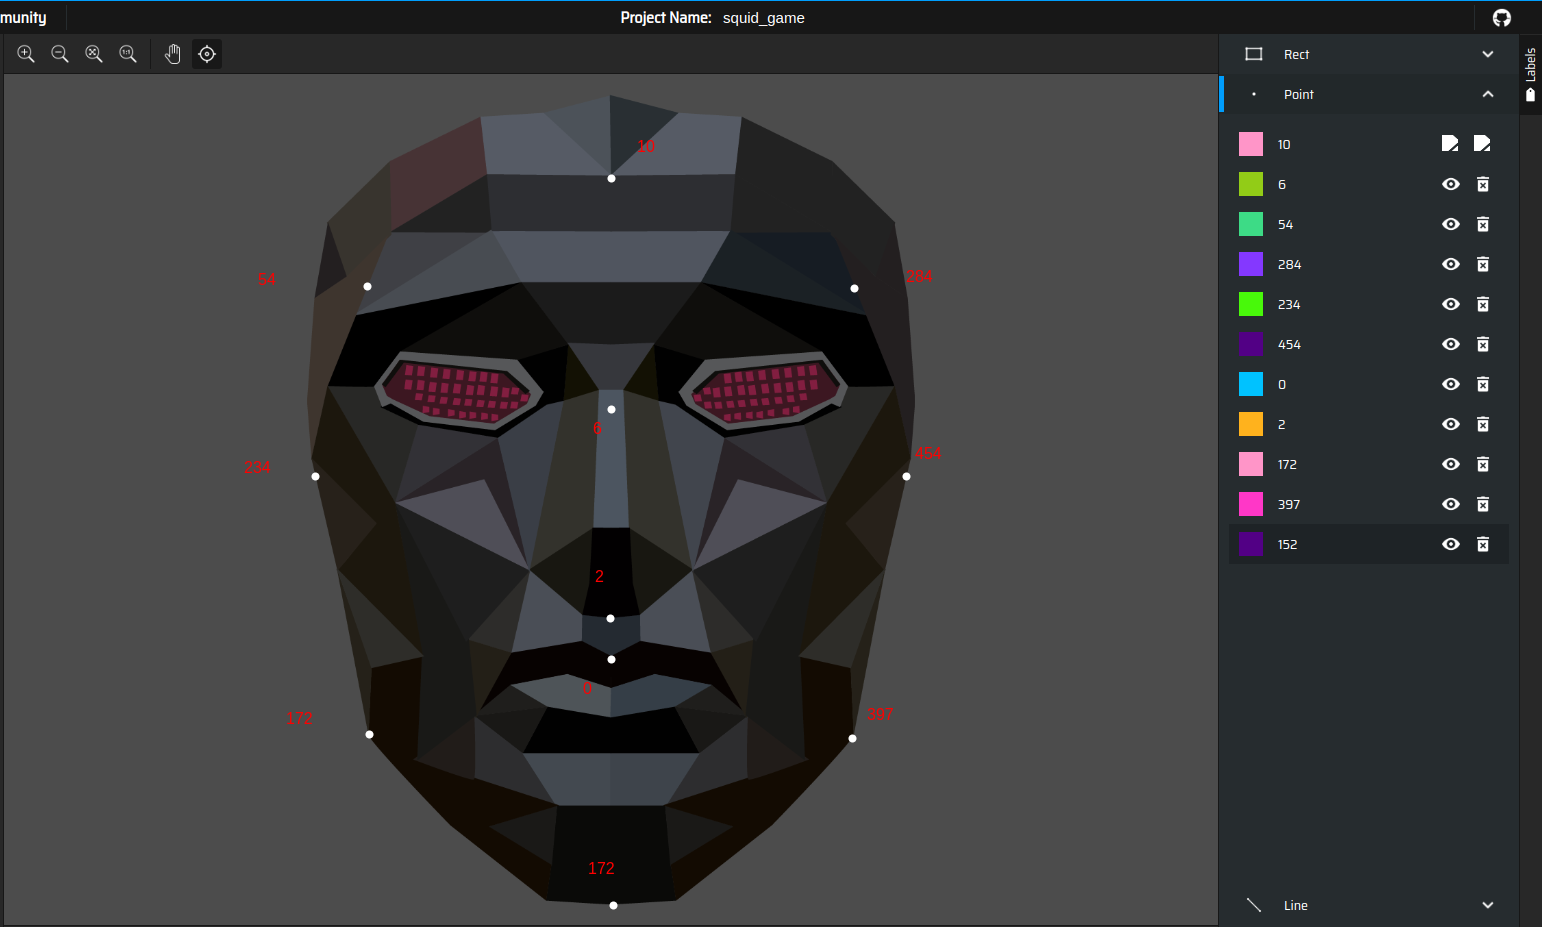

Export annotations from Makesense

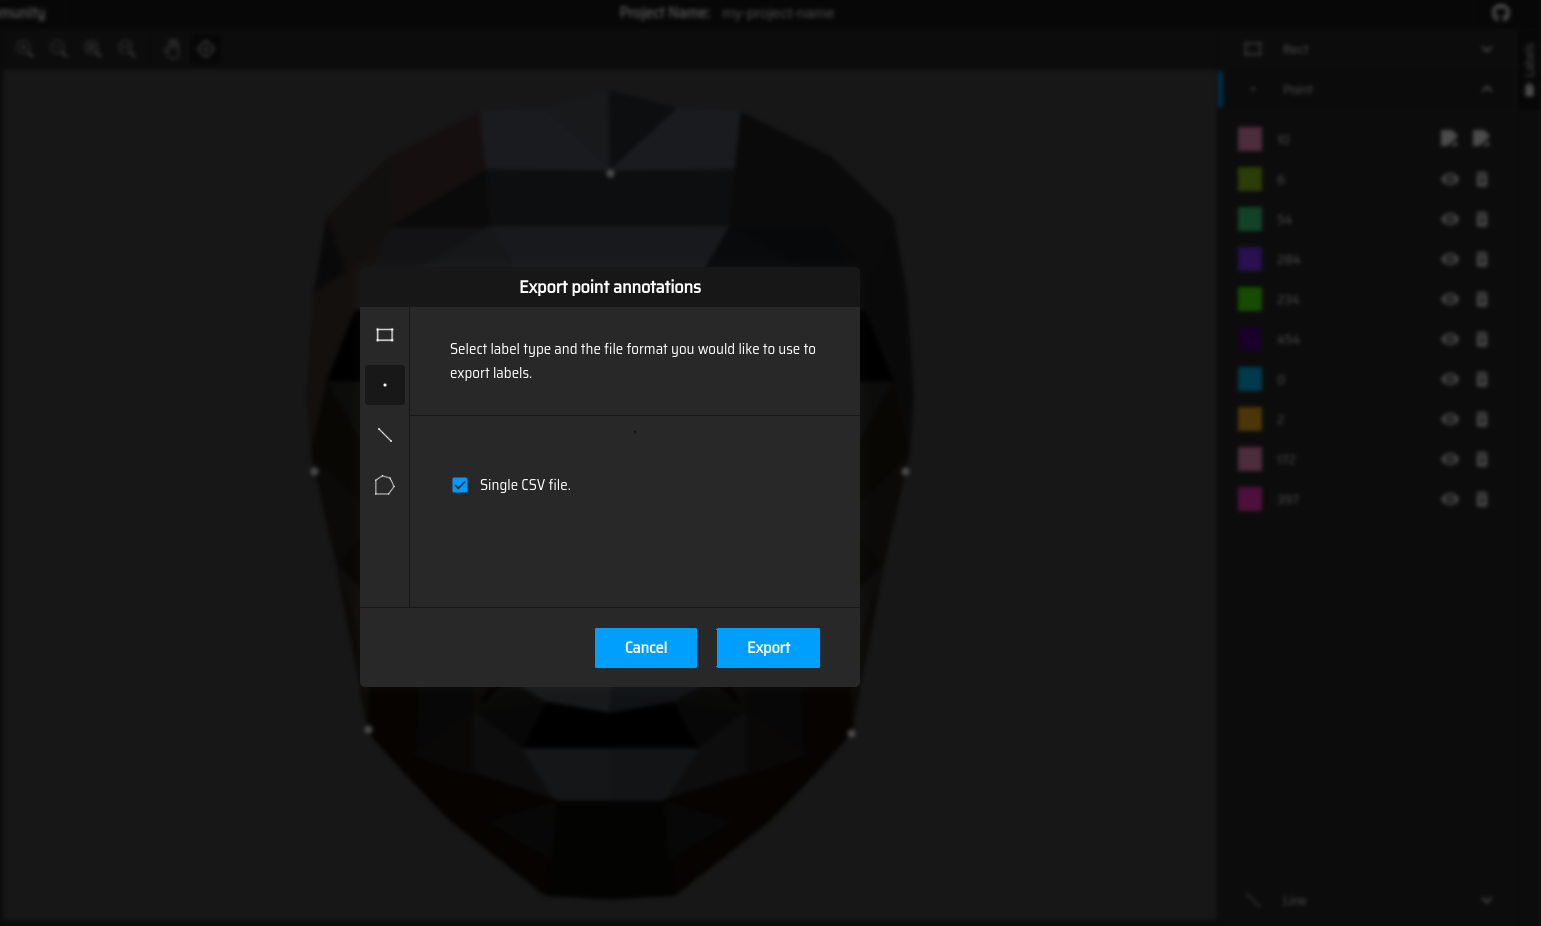

Convert makesense to mediapipe annotation

In [3]:
def makesense_converter(input_file_path, output_file_path):
    """
    A function to convert the annotation format of Makesense.ai to ours.
    """
    landmark_descriptions = {
        "10": "forehead",
        "6": "between eyes",
        "54": "right forehead",
        "284": "left forehead",
        "234": "right cheek",
        "454": "left cheek",
        "2": "lower nose",
        "0": "upper lip",
        "172": "right chin",
        "397": "left chin",
        "152": "lower chin"
    }
    # Read the input CSV file and extract the necessary data
    landmark_data = []
    with open(input_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            landmark_data.append({
                "landmark": row[0],
                "x": row[1],
                "y": row[2],
                "description": landmark_descriptions[str(row[0])]
            })

    # Write the extracted data to a new CSV file with the desired format
    with open(output_file_path, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
        # Write the header
        csv_writer.writerow(["landmark", "x", "y", "description"])
        # Write the rows
        for data in landmark_data:
            csv_writer.writerow([data["landmark"], data["x"], data["y"], data["description"]])
    return output_file_path

In [ ]:
print(makesense_converter("xxxxxxx", "data/Squid-Game-Front-Man-Mask.csv"))

FileNotFoundError: [Errno 2] No such file or directory: '/home/omar.sayed@ad.cyshield/Downloads/labels_squid_game_2024-07-21-02-25-42.csv'

Utilities

Capture video from web cam

Display masks layout on video frame

In [3]:
def display_img(output, face_land_img, masks_files, selected, hover):
    """
    This function basically places the landmarks and the mask images for selection
    """
    face_land_img = cv2.cvtColor(face_land_img, cv2.COLOR_BGR2BGRA)
    face_land_img = face_land_img / 255.0
    height, width = face_land_img.shape[:2]

    positions = []

    # Place landmark image on the top left corner
    if face_land_img is not None:
        output[:height, :width] = face_land_img
        output = cv2.rectangle(output, (0, 0), (width, height), (0, 0, 250), 5)

    # Place mask images on the right
    # Depending on the mask selected or hovered over, it shifts it
    #   to the left
    mask_height, mask_width = masks_files[0].shape[:2]
    for i, mask in enumerate(masks_files):
        if selected == i or hover == i:
            shift = 15
        else:
            shift = 0

        pos_y = [10 + i * 15 + i * mask_height, 10 + i * 15 + (i + 1) * mask_height]
        pos_x = [
            output.shape[1] - mask_width - 10 - shift,
            output.shape[1] - 10 - shift,
        ]
        positions.append(pos_y + pos_x)
        output[pos_y[0] : pos_y[1], pos_x[0] : pos_x[1]] = mask

        if selected == i:
            output = cv2.rectangle(
                output, (pos_x[0], pos_y[0]), (pos_x[1], pos_y[1]), (0, 200, 0), 3
            )

    return output, positions

Augment Mask on video frame

In [4]:
def warp_image(image, landmarks_coord, mask_file, mask_coord, selected):
    """
    This function receives the mask file and the locations of the \
    landmarks and warps the given image
    """
    im_src = cv2.imread(mask_file, cv2.IMREAD_UNCHANGED)
    pts_src = np.array(mask_coord, dtype=float)

    pts_dst = np.array(landmarks_coord, dtype=float)
    h, status = cv2.findHomography(pts_src, pts_dst)
    im_out = cv2.warpPerspective(im_src, h, (image.shape[1], image.shape[0]))

    src = im_out.astype(float)
    src = src / 255.0
    alpha_foreground = src[:, :, 3]

    dst = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    dst = dst.astype(float)
    dst = dst / 255.0

    # Additional code required for blending alpha parameter from mask
    # 	image to the live feed, hence the need of transparent backgrounds
    if selected != 0:
        for color in range(0, 3):
            dst[:, :, color] = (
                alpha_foreground * src[:, :, color]
                + (1 - alpha_foreground) * dst[:, :, color]
            )

    dst[:, :, :] = cv2.erode(dst[:, :, :], (5, 5), 0)
    dst[:, :, :] = cv2.GaussianBlur(dst[:, :, :], (3, 3), 0)

    return dst

Superhero Application

In [5]:
start = time.time()
mouse_coord = []
click = [0]

def hoverFunction(event, x, y, flags, param):
    """
    Function to select a different mask
    """
    global click
    if event == cv2.EVENT_MOUSEMOVE:
        refPt = [x, y]
        if mouse_coord:
            mouse_coord.pop()
        mouse_coord.append(refPt)

    if event == cv2.EVENT_LBUTTONDOWN:
        click = [1]


# -------------------------------------------------------------------------------------------------------------------------------------------------

# List the images' paths (PNG files must have transparent backgrounds)
mask_filenames = sorted(glob.glob(f'/home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/*.png'))

# List their corresponding landmark and pixel coordinates
# Landmarks correspond to the value given by MediaPipes library
# Pixel coordinates must match from the images to each landmark
csv_filenames = sorted(glob.glob(f'/home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/*.csv'))

# MediaPipe's functions to extract landmarks' coordinates and
#   face detection
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh
mp_face_detection = mp.solutions.face_detection

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1, color=(0, 0, 0))
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5
)
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.7)

# Read mask images to display on output image
mask_width = 70
mask_height = 100
masks_files = []

for file in mask_filenames:
    mask = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    mask = cv2.resize(mask, (mask_width, mask_height))
    mask = mask / 255.0
    masks_files.append(mask)

# Selection of mask variables
selected = 0
hover = 0

# Define image size parameters and open camera
height, width = 576, 768
video = cv2.VideoCapture(0)
ret, image = video.read()
image = cv2.resize(image, (width, height))

# Link the output imshow to the mouse callback function
face_land_img = None
cv2.namedWindow("Live")
cv2.setMouseCallback("Live", hoverFunction)

while ret:
    frame_start = time.time()

    # Depending on the mask selected, its corresponding image and
    #   landmark location are read
    csv_filename = csv_filenames[selected]
    img_filename = mask_filenames[selected]
    print(csv_filename, img_filename)
    landmarks, ids, mask_coordinates = read_csv(csv_filename)

    # Detection of landmarks
    image = cv2.flip(image, 1)
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    black_image = np.zeros((height, width, 3), np.uint8)
    black_image[::, ::] = (230, 230, 230)

    # Drawing the landmarks on a black image
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=black_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=drawing_spec,
                connection_drawing_spec=drawing_spec,
            )

    # Save the coordinates of the landmarks of interest
    landmarks_coordinates = []
    for landmark_of_interest in ids:
        x = int(face_landmarks.landmark[landmark_of_interest].x * width)
        y = int(face_landmarks.landmark[landmark_of_interest].y * height)
        landmarks_coordinates.append([x, y])

    # Face detection
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if not results.detections:
        continue

    # Extraction of face location from image
    for detection in results.detections:
        area = detection.location_data.relative_bounding_box
        x1 = int(area.xmin * width)
        y1 = int(area.ymin * height * 0.75)
        x2 = x1 + int(area.width * width)
        y2 = int(area.ymin * height) + int(area.height * height * 1.05)

        face_land_img = black_image[y1:y2, x1:x2]
        face_land_img = cv2.resize(face_land_img, (width // 5, height // 3))

    # Call warp function to apply homography with the face orientation
    #   and mask image
    output = warp_image(
        image, landmarks_coordinates, img_filename, mask_coordinates, selected
    )

    # Combine results in a single image for output
    result, positions = display_img(
        output, face_land_img, masks_files, selected, hover
    )

    # Pseudo-GUI feature to select the mask of interest
    if mouse_coord:
        hover = -1
        for i, pos in enumerate(positions):
            y1, y2, x1, x2 = pos
            if x1 <= mouse_coord[0][0] <= x2 and y1 <= mouse_coord[0][1] <= y2:
                hover = i
                if click[0]:
                    selected = i
                    click = [0]

    # Display of result and read the next frame
    cv2.imshow("Live", result)
    ret, image = video.read()
    image = cv2.resize(image, (width, height))

    # Press "q" to exit
    key = cv2.waitKey(1)
    if key == ord("q"):
        cv2.destroyAllWindows()
        break


    # Verify performance of program
    print(
        "\rFPS: {:7.5} Time Elapsed: {:7.5} seconds".format(
            1 / (time.time() - frame_start), time.time() - start
        ),
        end="",
    )

print("")
video.release()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1753187219.713123  161124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753187219.718548  161135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753187219.731554  161124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
QObject::moveToThread: Current thread (0x15effe40) is not the object's thread (0x16762930).
Cannot move to target thread (0x15effe40)

QObject::moveToThread: Current thread (0x15effe40) is not the object's thread (0x16762930).
Cannot move to target thread (0x15effe40)

QObject::moveToThread: Current thread (0x15effe40) is not the object's thread (0x16762930).
Cannot move to target thread (0x15ef

/home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/batman_1.csv /home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/batman_1.png
FPS:  6.3051 Time Elapsed:  2.1154 seconds/home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/batman_1.csv /home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/batman_1.png
FPS:  11.762 Time Elapsed:  2.2004 seconds/home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/batman_1.csv /home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/batman_1.png
FPS:  10.295 Time Elapsed:  2.2976 seconds/home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/batman_1.csv /home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/batman_1.png
FPS:  12.187 Time Elapsed:  2.3797 seconds/home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/batman_1.csv /home/esraa.elshabrawy@ad.cyshield/Superhero_Mask_Overlay/data/batman_1.png
FPS:  10.141 Time Elapsed:  2.4784 seconds/home/esraa.elshabrawy@ad.cysh

IndexError: list index out of range